In [27]:
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/tools.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_kmeans.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_sifts.py

--2019-09-27 20:56:07--  https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12730 (12K) [text/plain]
Saving to: ‘tools.py.1’

tools.py.1          100%[===================>]  12.43K  --.-KB/s    in 0s      

2019-09-27 20:56:07 (108 MB/s) - ‘tools.py.1’ saved [12730/12730]

--2019-09-27 20:56:09--  https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_kmeans.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491 [text/plain]
Saving to: ‘compute_kmeans.py.1’

comput

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!unzip /content/drive/My\ Drive/data.zip -d /content/

Archive:  /content/drive/My Drive/data.zip
replace /content/data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Partie 1 : SIFT

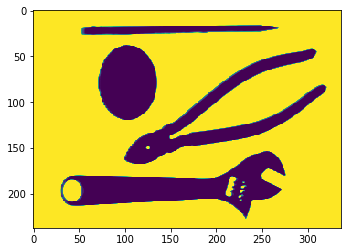

In [31]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

In [0]:
h_x = np.asarray([1,0,-1])
h_y = np.asarray([-1,-2,-1])
Iy = conv_separable(I, h_x, h_y)
Ix = conv_separable(I, h_y, h_x)

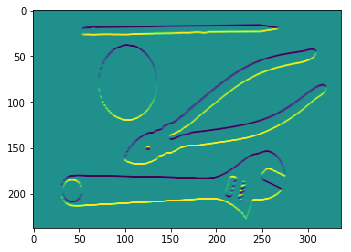

In [106]:
plt.imshow(Ix)

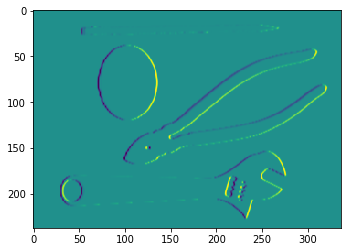

In [107]:
plt.imshow(Iy)

In [0]:
def compute_grad(I):
    h_x = np.asarray([1,0,-1])
    h_y = np.asarray([-1,-2,-1])
    Iy = conv_separable(I, h_x, h_y)
    Ix = conv_separable(I, h_y, h_x)

    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [0]:
def compute_grad_mod_ori(I):
    # TODO
    return Gm, Go

In [0]:
def compute_sift_region(Gm, Go, mask=None):
    # TODO
    # Note: to apply the mask only when given, do:
    if mask is not None:
        pass # TODO apply mask here
    return sift

In [0]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
#display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [0]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    # TODO calculs communs aux patchs
    sifts = np.zeros(len(x), len(y), 128)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            sifts[i, j, :] = None # TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

# Partie 2 : Dictionnaire visuel

In [0]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

In [0]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [0]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

In [0]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector

In [0]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

In [0]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

# Partie 3 : BoW

In [0]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    return

In [0]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here